In [61]:

import numpy as np
import tensorflow as tf
import deepxde as dde
import geopandas as gpd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from pykrige.ok import OrdinaryKriging
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import norm, lognorm
import xarray as xr
from sklearn.preprocessing import StandardScaler
import geopandas as gpd
import requests
from bs4 import BeautifulSoup
import pandas as pd

dde.config.set_default_float("float32")


Set the default float type to float32


In [62]:
import warnings
warnings.filterwarnings("ignore")

In [63]:
# Configurazioni e percorsi
# Configurazioni e percorsi
FIGURE_PATH = "C:/Users/vitas/Desktop/LE PINN/pinn.global.dust/pinn.global.dust/Code/figures/"
DATA_PATH = "C:/Users/vitas/Desktop/LE PINN/pinn.global.dust/pinn.global.dust/Data/"
DATA_LOAD_PATH = DATA_PATH + "original_data/"
INPUT_MODEL_PATH = DATA_PATH + "processed_data/"
MODEL_SAVE_PATH = DATA_PATH + "trained_models/"
RESULTS_PATH = DATA_PATH + "model_results/"
path_to_shapefile ="C:/Users/vitas/Desktop/LE PINN/pinn.global.dust/pinn.global.dust/ne_110m_admin_0_countries.shp"
world = gpd.read_file(path_to_shapefile)

In [64]:
with open("functions_training_model.py", 'r') as file:
    content = file.read()

# Execute the content of the .py file
exec(content)

In [65]:
df_simulated_Holocene = pd.read_csv(INPUT_MODEL_PATH + "df_simulation_Holocene.csv")
df_global_grid = pd.read_csv(INPUT_MODEL_PATH + "df_global_grid.csv")
df_wind = pd.read_csv(INPUT_MODEL_PATH + "df_wind.csv", usecols=['wind', 'latitude'])

latitude_wind, mean_wind = df_wind['latitude'].values/90, df_wind['wind'].values/df_wind['wind'].max()

def wind_latitude(latitude):
    interpolated = wind_tf_interp(latitude, tf.convert_to_tensor(latitude_wind), tf.convert_to_tensor(mean_wind))
    return interpolated

tf_wind_latitude = tf.function(wind_latitude)


In [66]:
def training_points(df):
    data_observ_points = dde.data.DataSet(
        X_train=df[['lon', 'lat']].values / 90,
        y_train=df['log_dep_norm'].values.reshape(-1, 1),
        X_test=df[['lon', 'lat']].values / 90,
        y_test=df['log_dep_norm'].values.reshape(-1, 1),
        standardize=False)

    observe_u = dde.icbc.PointSetBC(data_observ_points.train_x,
                                    df['log_dep_norm'].values.reshape(-1, 1), component=0)

    return data_observ_points, observe_u

In [67]:
x_min, x_max = -2.0, 2.0
y_min, y_max = -0.89, 0.89

left_corner = np.array([x_min, y_min])  # xmin, ymin – Coordinate of bottom left corner.
right_corner = np.array([x_max, y_max])  # xmax, ymax – Coordinate of top right corner.
geometry_rectangle = dde.geometry.geometry_2d.Rectangle(left_corner, right_corner)

# Reduce the training domain to avoid pole singularities.
df_simulated_Holocene_2 = df_simulated_Holocene[
    (df_simulated_Holocene['lat'] >= -81) & (df_simulated_Holocene['lat'] <= 81)]


In [68]:
def pde(x, u):
    du_x = dde.grad.jacobian(u, x, j=0)  # du/dlambda
    du_y = dde.grad.jacobian(u, x, j=1)  # du/dtheta

    K = wind_latitude(x[:, 1:2])
    K = tf.cast(K, tf.float32)

    du_xx = dde.grad.hessian(u, x, i=0, j=0)  # d^2u/dlambda^2
    du_yy = dde.grad.hessian(u, x, i=1, j=1)  # d^2u/dtheta^2

    return (
        (-K * du_x * (1 / tf.cos(x[:, 1:2] * np.pi / 2)) + D * ((1 / (tf.cos(x[:, 1:2] * np.pi / 2) ** 2) * du_xx + du_yy - tf.tan(x[:, 1:2] * np.pi / 2) * du_y)))
    )

In [69]:
def space_boundary_north(x, on_boundary):
    return on_boundary and np.isclose(y_max, x[1])

def space_boundary_south(x, on_boundary):
    return on_boundary and np.isclose(y_min, x[1])

def periodic_boundary(x, domain):
    return domain and (np.isclose(x[0], x_min) or np.isclose(x[0], x_max))

In [70]:
def train_process(data_observ_points, observe_u, D, bc_1, bc_2, model_name):
    data = dde.data.PDE(
        geometry_rectangle,
        pde,
        [observe_u, periodic_condition, periodic_condition_derivative, bc_1, bc_2],
        num_domain=2592,
        num_boundary=216,
        anchors=data_observ_points.train_x,
        train_distribution='uniform'
    )

    neurons = 32
    layer = 5
    layer_size = [2] + [neurons] * layer + [1]
    activation = "selu"
    initializer = "Glorot normal"
    net = dde.maps.FNN(layer_size, activation, initializer)
    model = dde.Model(data, net)
    dde.optimizers.set_LBFGS_options(maxcor=50, ftol=1e-20, maxiter=1e5)
    model.compile("adam", lr=0.00001, external_trainable_variables=[D, north_mean, south_mean],
                  loss_weights=[1, 10, 0.5, 0.5, 1, 1])

    # Train and save the model
    import os
    os.makedirs(MODEL_SAVE_PATH + model_name, exist_ok=True)

    checkpointer = dde.callbacks.ModelCheckpoint(
        f"{MODEL_SAVE_PATH}{model_name}/{model_name}.ckpt",
        verbose=0, period=10000,
    )

    variable = dde.callbacks.VariableValue([D, north_mean, south_mean], period=10000,
                                           filename=MODEL_SAVE_PATH + model_name + "/variables.dat")

    losshistory, train_state = model.train(epochs=10000, callbacks=[variable, checkpointer])
    dde.saveplot(losshistory, train_state, issave=False, isplot=True)
    params = variable.get_value()

    return model, params, train_state.best_step,losshistory

In [71]:
north_mean = dde.Variable(-1.0)
south_mean = dde.Variable(-2.0)
D = dde.Variable(1.0)

bc_1 = dde.DirichletBC(geometry_rectangle, lambda x: north_mean, space_boundary_north)
bc_2 = dde.DirichletBC(geometry_rectangle, lambda x: south_mean, space_boundary_south)

periodic_condition = dde.icbc.PeriodicBC(geom=geometry_rectangle, component_x=0, on_boundary=periodic_boundary,
                                         derivative_order=0)
periodic_condition_derivative = dde.icbc.PeriodicBC(geom=geometry_rectangle, component_x=0,
                                                    on_boundary=periodic_boundary, derivative_order=1)


In [72]:
# Selezione regione (bounding box)
# --------------------------------------------------
lon_min_box, lon_max_box = -90, 30   # aggiorna qui
lat_min_box, lat_max_box = -70, -10   # aggiorna qui
mask_box = (
    (df_simulated_Holocene_2['lon'] >= lon_min_box) & (df_simulated_Holocene_2['lon'] <= lon_max_box) &
    (df_simulated_Holocene_2['lat'] >= lat_min_box) & (df_simulated_Holocene_2['lat'] <= lat_max_box)
)
df_box   = df_simulated_Holocene_2[mask_box]
df_train = df_simulated_Holocene_2[~mask_box]
print(f"Regione: lon [{lon_min_box},{lon_max_box}], lat [{lat_min_box},{lat_max_box}] -> test points: {len(df_box)}")


Regione: lon [-90,30], lat [-70,-10] -> test points: 6111


Compiling model...
Building feed-forward neural network...
'build' took 1.082642 s

'compile' took 11.114386 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [8.00e+01, 1.48e+01, 1.58e+00, 1.44e-01, 7.33e-01, 2.55e+00]    [8.00e+01, 1.48e+01, 1.58e+00, 1.44e-01, 7.33e-01, 2.55e+00]    []  
1000      [6.99e+00, 6.71e+00, 1.33e-01, 2.52e-02, 1.96e+00, 9.81e-01]    [6.99e+00, 6.71e+00, 1.33e-01, 2.52e-02, 1.96e+00, 9.81e-01]    []  
2000      [3.61e+00, 5.72e+00, 4.97e-02, 3.98e-02, 2.01e+00, 1.12e+00]    [3.61e+00, 5.72e+00, 4.97e-02, 3.98e-02, 2.01e+00, 1.12e+00]    []  
3000      [2.23e+00, 5.12e+00, 5.89e-02, 5.50e-02, 1.97e+00, 1.04e+00]    [2.23e+00, 5.12e+00, 5.89e-02, 5.50e-02, 1.97e+00, 1.04e+00]    []  
4000      [1.75e+00, 4.29e+00, 7.81e-02, 6.40e-02, 1.83e+00, 8.53e-01]    [1.75e+00, 4.29e+00, 7.81e-02, 6.40e-02, 1.83e+00, 8.53e-01]    []  
5000

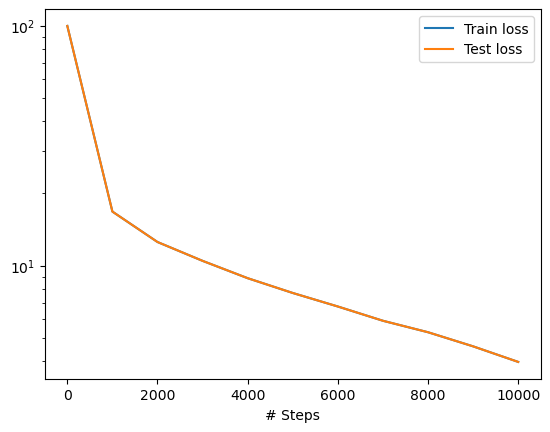

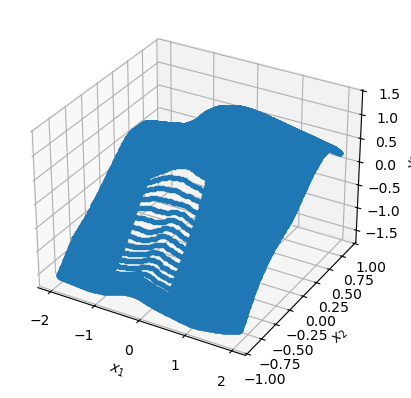

PINN MSE sulla regione: 0.6587


In [73]:
# Addestramento PINN e stima errori
# --------------------------------------------------
data_obs, bc_point = training_points(df_train)
pinn_model, _, _, losshistory = train_process(data_obs, bc_point, D, bc_1, bc_2, 'model_region')
Xg = (df_box[['lon','lat']].values/90.0).astype(np.float32)
Yg = df_box['log_dep_norm'].values.reshape(-1,1).astype(np.float32)
pinn_g = pinn_model.predict(Xg)
mse_pinn = np.mean((pinn_g - Yg)**2)
print(f"PINN MSE sulla regione: {mse_pinn:.4f}")


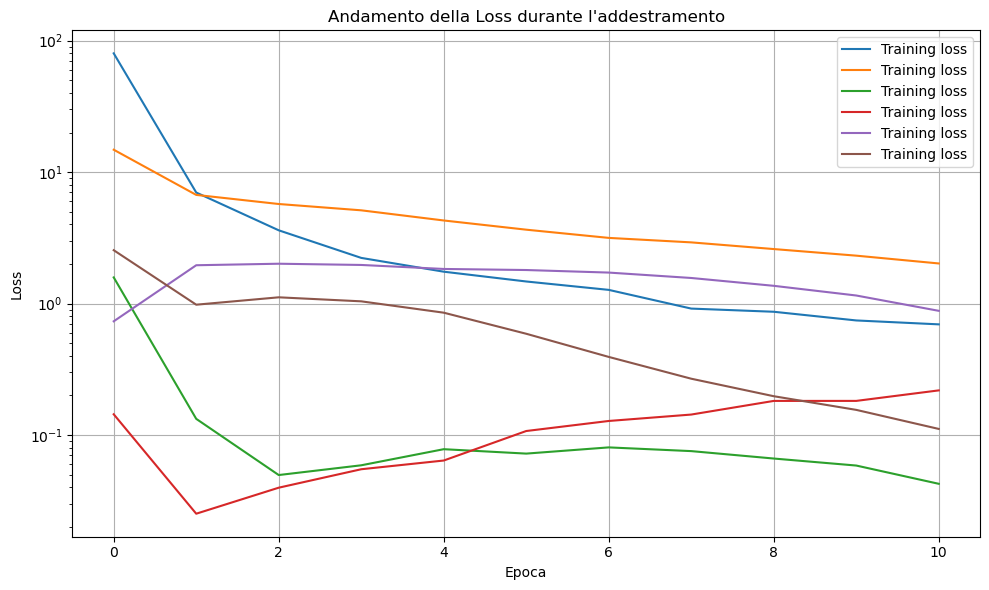

In [74]:
import matplotlib.pyplot as plt


# Estrai le epoche
epochs = range(len(losshistory.loss_train))

# Loss totale durante il training
plt.figure(figsize=(10, 6))
plt.plot(epochs, losshistory.loss_train, label="Training loss")

# Se disponibile: validation loss
#if losshistory.loss_test:
 #   plt.plot(epochs, losshistory.loss_test, label="Test loss")

plt.xlabel("Epoca")
plt.ylabel("Loss")
plt.title("Andamento della Loss durante l'addestramento")
plt.yscale("log")  # utile se le loss coprono più ordini di grandezza
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [80]:
# Kriging vettorializzato e stima errori
# --------------------------------------------------
lon_tr = df_train['lon'].values
lat_tr = df_train['lat'].values
val_tr = df_train['log_dep'].values
Yg = df_box['log_dep'].values.astype(np.float32)
lon_pred = df_global_grid['lon'].values
lat_pred = df_global_grid['lat'].values
n_sub  = min(len(lon_tr), 1000)
np.random.seed(42)
idx_sub = np.random.choice(len(lon_tr), n_sub, replace=False)
ok = OrdinaryKriging(
    lon_tr[idx_sub], lat_tr[idx_sub], val_tr[idx_sub],
    variogram_model='linear', verbose=False, enable_plotting=False
)

krig_pred, krig_var = ok.execute('points', lon_pred, lat_pred)
# 1. per predire con Kriging MSE
krig_arr, _ = ok.execute('points', df_box['lon'].values, df_box['lat'].values)
mse_kriging = np.mean((krig_arr - Yg) ** 2)

print(f"MSE Kriging : {mse_kriging:.6f}")



MSE Kriging : 0.432644


In [81]:
with open("functions_plot_calculations.py", 'r') as file:
    content = file.read()

# Execute the content of the .py file
exec(content)

In [86]:
def calculate_save_df(model, df_to_predict, mean, std, path, filename):
    "Perform the predictions and save the results."
    U_pred = model.predict(df_to_predict[['lon', 'lat']].values/90)
    U_pred_denorm = (U_pred * std) + mean
    df_to_predict['PINN_log_dep'] = U_pred_denorm
    df_to_predict.to_csv(path + filename, index=False)

def calculate_save_kriging_df(ok_model, df_to_predict, path, filename):
    """
    Esegue la predizione con Kriging su df_to_predict e salva il risultato.
    ok_model: oggetto OrdinaryKriging già addestrato
    df_to_predict: DataFrame con colonne 'lon' e 'lat'
    """
    # Esegui predizione (già in scala originale)
    krig_arr, _ = ok_model.execute('points', df_to_predict['lon'].values, df_to_predict['lat'].values)

    # Aggiungi la colonna al DataFrame (senza denormalizzazione!)
    df_to_predict['Kriging_log_dep'] = krig_arr

    # Salva il risultato
    df_to_predict.to_csv(path + filename, index=False)


mean = df_simulated_Holocene['log_dep'].mean()
std = df_simulated_Holocene['log_dep'].std()

calculate_save_df(pinn_model, df_box, mean, std, RESULTS_PATH, "df_pinn_Patagonia.csv")
calculate_save_df(pinn_model, df_global_grid, mean, std, RESULTS_PATH, "df_pinn_grid_Patagonia.csv")
calculate_save_kriging_df(ok, df_box, RESULTS_PATH, "df_kriging_Patagonia.csv")
calculate_save_kriging_df(ok, df_global_grid, RESULTS_PATH, "df_kriging_grid_Patagonia.csv")




In [88]:
df_pinn_grid_Patagonia=pd.read_csv("C:/Users/vitas/Desktop/LE PINN/pinn.global.dust/pinn.global.dust/Data/model_results/df_pinn_grid_Patagonia.csv  ")
df_pinn_Patagonia = pd.read_csv( "C:/Users/vitas/Desktop/LE PINN/pinn.global.dust/pinn.global.dust/Data/model_results/df_pinn_Patagonia.csv")
df_kriging_grid_Patagonia=pd.read_csv("C:/Users/vitas/Desktop/LE PINN/pinn.global.dust/pinn.global.dust/Data/model_results/df_kriging_grid_Patagonia.csv")
df_kriging_Patagonia = pd.read_csv("C:/Users/vitas/Desktop/LE PINN/pinn.global.dust/pinn.global.dust/Data/model_results/df_kriging_Patagonia.csv")


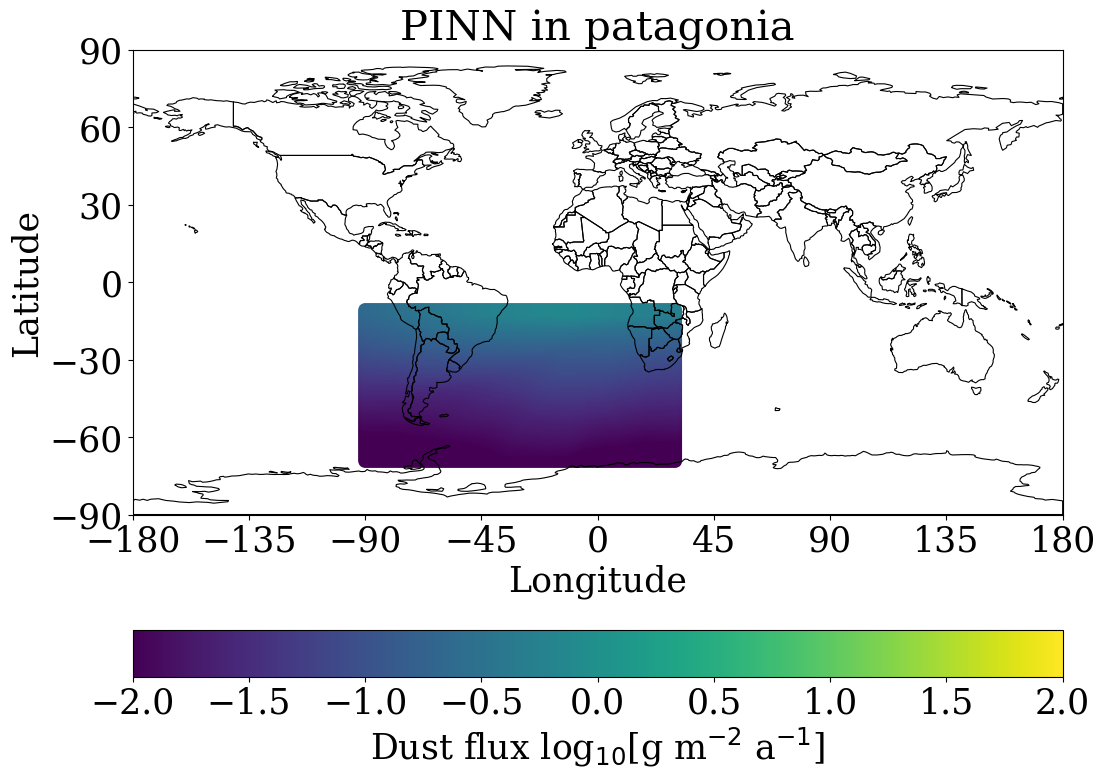

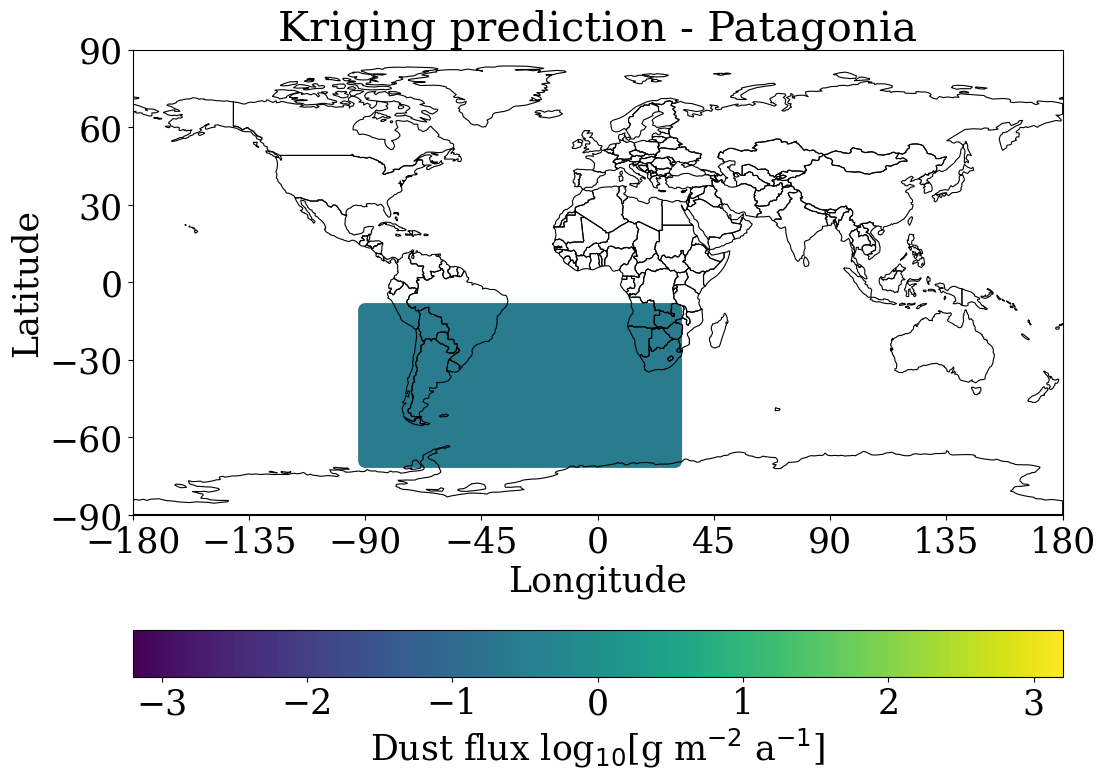

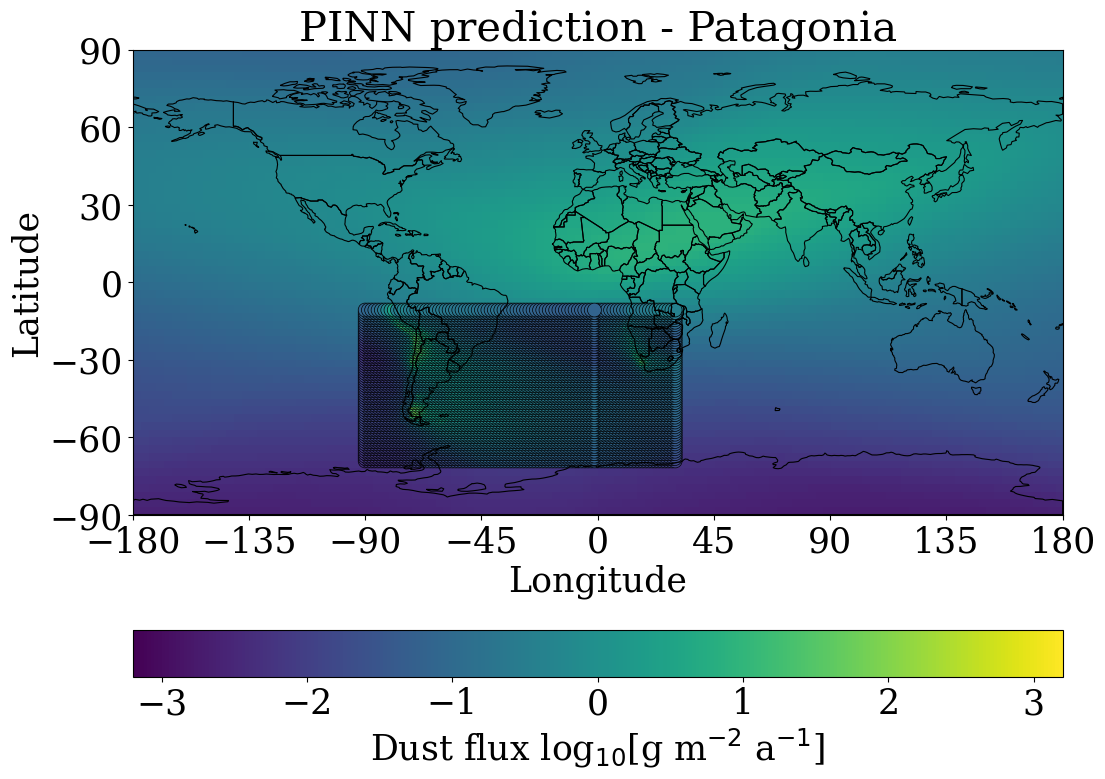

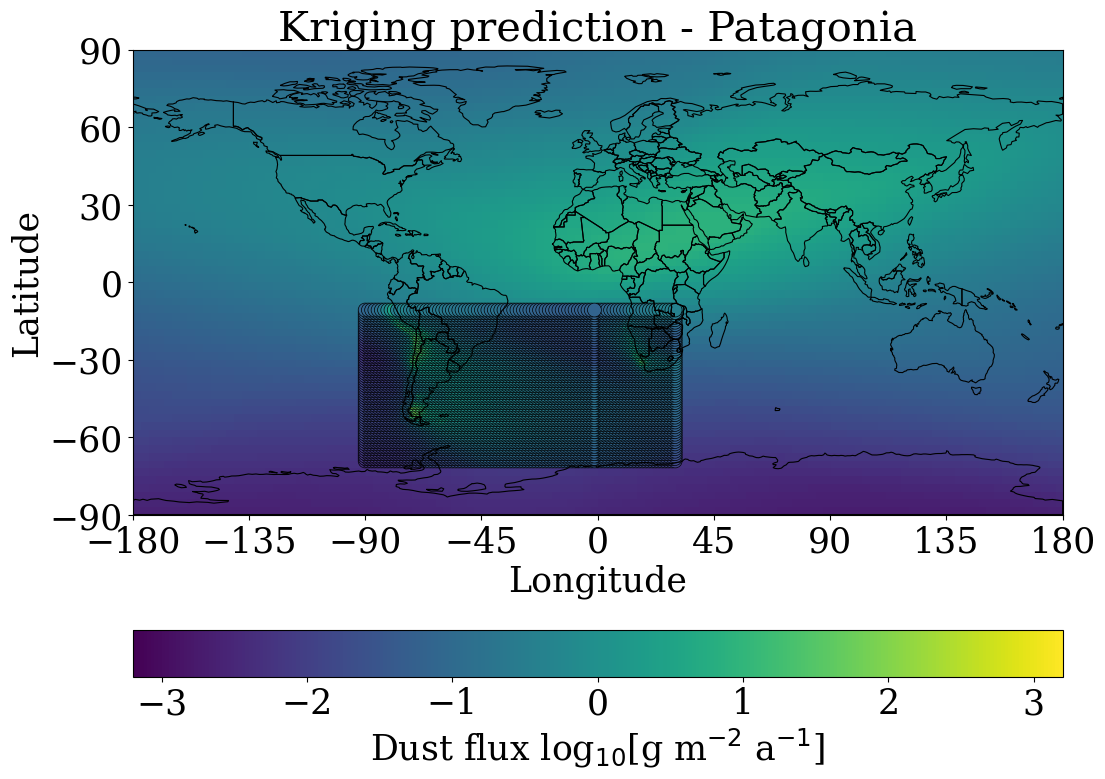

In [91]:
plot_dust_deposition_simulated(

     df=df_pinn_Patagonia,

     title='PINN in patagonia',
     name_to_save='PINN_MAP_simulated_patagonia',
     figure_save_path=FIGURE_PATH,
     label_str='PINN_log_dep',
limit_bar=2
)

plot_dust_deposition_simulated(
    df=df_kriging_Patagonia,
    title='Kriging prediction - Patagonia',
    name_to_save='Kriging_MAP_simulated_Patagonia',
    figure_save_path=FIGURE_PATH,
    label_str='Kriging_log_dep',)

plot_dust_deposition_map(
    df_pinn_grid_Patagonia,
    df_pinn_Patagonia,
    title='PINN prediction - Patagonia',
    name_to_save='Pinn_MAP_Patagonia',
    figure_save_path=FIGURE_PATH,
    label_str='PINN_log_dep',)

plot_dust_deposition_map(
    df_pinn_grid_Patagonia,
    df_pinn_Patagonia,
    title='Kriging prediction - Patagonia',
    name_to_save='Kriging_MAP_Patagonia',
    figure_save_path=FIGURE_PATH,
    label_str='Kriging_log_dep',)



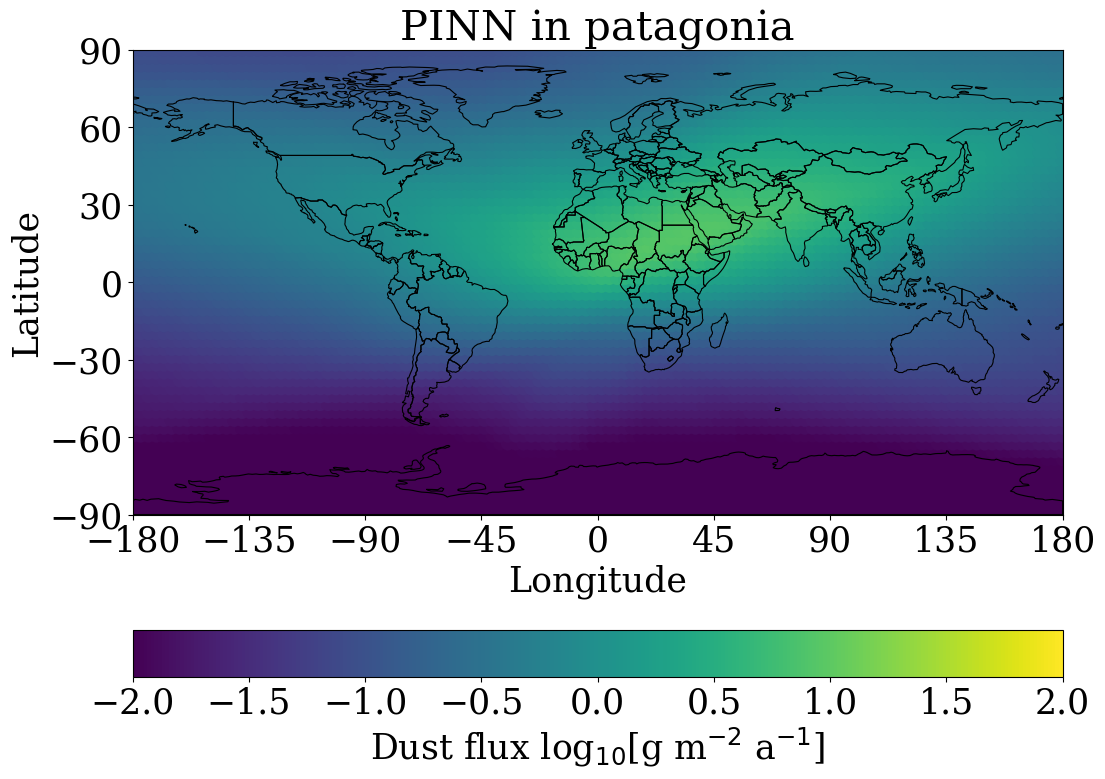

In [92]:
plot_dust_deposition_simulated(

     df=df_pinn_grid_Patagonia,

     title='PINN in patagonia',
     name_to_save='PINN_MAP_simulatedgrid_patagonia',
     figure_save_path=FIGURE_PATH,
     label_str='PINN_log_dep',
limit_bar=2)